In [1]:
from __future__ import print_function
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt

import wfdb
import time
import random
from sklearn.preprocessing import minmax_scale
import sys



In [2]:
def split_ecg_signal(ecg_signal, window_size=10, sampling_rate=1000):
    """
    Step 1: Splitting the continuous ECG signal to 10s windows and select a 10s window.
    """
    window_length = window_size * sampling_rate
    num_windows = len(ecg_signal) // window_length
    windows = [ecg_signal[i*window_length:(i+1)*window_length] for i in range(num_windows)]
    return windows

In [3]:
def normalize_signal(ecg_signal):
    """
    Step 2: Normalizing the amplitude values to the range between zero and one.
    """
    min_val = np.min(ecg_signal)
    max_val = np.max(ecg_signal)
    normalized_signal = (ecg_signal - min_val) / (max_val - min_val)
    return normalized_signal


In [35]:
from scipy.signal import find_peaks
def find_local_maxima(ecg_signal):
    """
    Step 3: Finding the set of all local maximums based on zero-crossings of the first derivative.
    """
    first_derivative = np.diff(ecg_signal)
    peaks, _ = find_peaks(first_derivative, height=0)
    # Convert peak indices to values
    
    local_maxima_values =ecg_signal[peaks]
    
    return [local_maxima_values,peaks]
    

In [66]:

def find_r_peak_candidates(local_maxima, threshold=0.9):
    """
    Step 4: Finding the set of ECG R-peak candidates by applying a threshold of 0.9 on the normalized value of the local maximums.
    """
    count=0
    peak_indices=[]
    peak_values=[]
    for lm in local_maxima:
        x=normalize_signal(lm)
        print(x)
        v=[lm[i] for i in range(len(x)) if x[i]>0.9]
        p=[i for i in range(len(x)) if x[i]>0.9]
        peak_indices.append(p)
        peak_values.append(v)
        count+=len(p)
    print(count)
    return  [peak_indices, peak_values]
        
        
   

In [69]:

def find_rr_intervals(peak_indices, sampling_rate=1000):
    """
    Step 5: Finding the median of R-R time intervals as the nominal heartbeat period of that window (T).
    """
    rr_intervals = np.diff(peak_indices)
    median_rr_interval = np.median(rr_intervals)
    return median_rr_interval

In [71]:
def select_signal_parts(ecg_signal, r_peak_indices, median_rr_interval):
    """
    Step 6: For each R-peak, selecting a signal part with the length equal to 1.2T.
    """
    selected_parts = []
    window_length = int(1.2 * median_rr_interval)
    for r_peak in r_peak_indices:
        peak_index=r_peak
        start_index = max(0, peak_index - window_length // 2)
        end_index = min(len(ecg_signal), peak_index + window_length // 2)
        selected_part = ecg_signal[start_index:end_index]
        selected_parts.append(selected_part)
    return selected_parts

In [8]:
def pad_signal_parts(selected_parts, fixed_length):
    """
    Step 7: Padding each selected part with zeros to make its length equal to a predefined fixed length.
    """
    padded_parts = [np.pad(part, (0, max(0, fixed_length - len(part))), 'constant') for part in selected_parts]
    return padded_parts

In [ ]:
# Example usage
ecg_signal = np.random.rand(10000)  # Example ECG signal (random values for demonstration)
windows = split_ecg_signal(ecg_signal)
normalized_signal = normalize_signal(ecg_signal)
local_maxima = find_local_maxima(normalized_signal)
r_peak_candidates = find_r_peak_candidates(local_maxima)

median_rr_interval = find_rr_intervals(r_peak_candidates)
selected_parts = select_signal_parts(ecg_signal, r_peak_candidates, median_rr_interval)
fixed_length = 188  # Example fixed length for padding
padded_parts = pad_signal_parts(selected_parts, fixed_length)


In [8]:
import wfdb

In [9]:
channel_1="ii"

In [10]:
d, _ = wfdb.rdsamp("C:\Final Project\ptbdb_data/patient170/s0274lre" , channel_names=[str(channel_1)])
print(d, type(d))

[[-0.1795]
 [-0.182 ]
 [-0.1815]
 ...
 [ 0.186 ]
 [ 0.188 ]
 [ 0.197 ]] <class 'numpy.ndarray'>


In [11]:
print(d.shape)


(115200, 1)


In [12]:
ecg_signal = np.random.rand(10000)

In [13]:
print(type(ecg_signal))

<class 'numpy.ndarray'>


In [14]:
print(ecg_signal.shape)

(10000,)


In [15]:
at = np.squeeze(d)

# Verify the shape
print("Original shape:", d.shape)
print("Transformed shape:", at.shape)

Original shape: (115200, 1)
Transformed shape: (115200,)


In [31]:
ecg_signal=d
windows = split_ecg_signal(ecg_signal)
print(windows)
print(type(windows[0]))
#list of numpy arrays
print(len(windows))


[array([[-0.1795],
       [-0.182 ],
       [-0.1815],
       ...,
       [-0.007 ],
       [-0.0105],
       [-0.018 ]]), array([[-0.0185],
       [-0.0185],
       [-0.015 ],
       ...,
       [ 0.0295],
       [ 0.0395],
       [ 0.044 ]]), array([[0.045 ],
       [0.0485],
       [0.0535],
       ...,
       [0.1325],
       [0.143 ],
       [0.1515]]), array([[ 0.1495],
       [ 0.141 ],
       [ 0.1295],
       ...,
       [-0.1185],
       [-0.1125],
       [-0.114 ]]), array([[-0.1195],
       [-0.125 ],
       [-0.1255],
       ...,
       [-0.1665],
       [-0.174 ],
       [-0.1825]]), array([[-0.1795],
       [-0.175 ],
       [-0.173 ],
       ...,
       [-0.0955],
       [-0.095 ],
       [-0.096 ]]), array([[-0.1025],
       [-0.1085],
       [-0.1115],
       ...,
       [-0.134 ],
       [-0.1265],
       [-0.1275]]), array([[-0.124 ],
       [-0.122 ],
       [-0.129 ],
       ...,
       [ 0.0755],
       [ 0.0635],
       [ 0.056 ]]), array([[ 0.0485],
       [ 0.

In [32]:
records=[]
for w in windows:
    normalized_signal = normalize_signal(w)
    records.append(normalized_signal)
print(len(records))
print(records[0])


11
[[0.43532338]
 [0.43283582]
 [0.43333333]
 ...
 [0.60696517]
 [0.60348259]
 [0.5960199 ]]


In [39]:
lm=[]
peaks=[]
for r in records:
    r= np.squeeze(r)
    print(type(r), r.shape)
    a= find_local_maxima(r)
    local_maxima=a[0]
    p=a[1]
    print(type(local_maxima), local_maxima.shape)
    lm.append(local_maxima[:2000] )
    peaks.append(p[:2000] )


<class 'numpy.ndarray'> (10000,)
<class 'numpy.ndarray'> (2336,)
<class 'numpy.ndarray'> (10000,)
<class 'numpy.ndarray'> (2328,)
<class 'numpy.ndarray'> (10000,)
<class 'numpy.ndarray'> (2331,)
<class 'numpy.ndarray'> (10000,)
<class 'numpy.ndarray'> (2302,)
<class 'numpy.ndarray'> (10000,)
<class 'numpy.ndarray'> (2274,)
<class 'numpy.ndarray'> (10000,)
<class 'numpy.ndarray'> (2235,)
<class 'numpy.ndarray'> (10000,)
<class 'numpy.ndarray'> (2280,)
<class 'numpy.ndarray'> (10000,)
<class 'numpy.ndarray'> (2211,)
<class 'numpy.ndarray'> (10000,)
<class 'numpy.ndarray'> (2254,)
<class 'numpy.ndarray'> (10000,)
<class 'numpy.ndarray'> (2264,)
<class 'numpy.ndarray'> (10000,)
<class 'numpy.ndarray'> (2252,)


In [40]:
print(type(lm),len(lm))
print(type(lm[0]))

<class 'list'> 11
<class 'numpy.ndarray'>


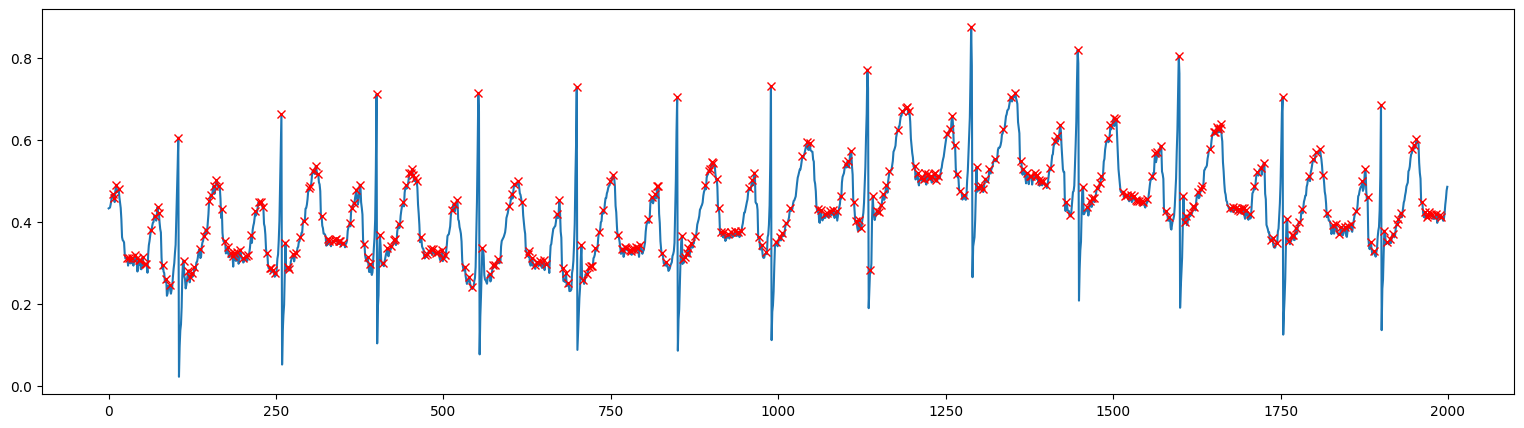

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from scipy import signal
peak, _ = find_peaks(lm[0],height=0)
fig= plt.figure(figsize=(19,5))
plt.plot(lm[0])
plt.plot(peak, lm[0][peak], "x", color = 'r')

In [42]:
plt.show()

In [67]:
p = find_r_peak_candidates(lm)
r_peak_indices=p[0]
r_peak_values=p[1]

[0.48109366 0.48225713 0.48342059 ... 0.50901687 0.53228621 0.54275742]
[0.53251318 0.54540129 0.55301699 ... 0.50966608 0.52138254 0.5178676 ]
[0.48697395 0.49565798 0.50167001 ... 0.37742151 0.38076152 0.38009352]
[0.43290286 0.42728804 0.42897249 ... 0.23076923 0.24536777 0.25379001]
[0.40967092 0.40564137 0.40832774 ... 0.37340497 0.36467428 0.35594359]
[0.34385061 0.34835802 0.33805538 ... 0.61043142 0.60721185 0.61751449]
[0.48182957 0.49874687 0.5        ... 0.47556391 0.47807018 0.49373434]
[0.32419257 0.33028641 0.34613041 ... 0.80377818 0.15783059 0.2480195 ]
[0.48937677 0.48016997 0.41501416 ... 0.48441926 0.50991501 0.50566572]
[0.25447316 0.2518224  0.25248509 ... 0.48111332 0.48707753 0.50298211]
[0.37246681 0.37526205 0.3780573  ... 0.33892383 0.3256464  0.32983927]
65


In [68]:
print(r_peak_indices,r_peak_values)

[[1288, 1447, 1598], [113, 244, 245, 387], [496, 497, 646, 647, 799, 947, 1112, 1268, 1417, 1558, 1559, 1713], [148, 310, 311, 463, 1505, 1650, 1651], [328, 329, 466, 467, 1476], [1322, 1470, 1606, 1748, 1884, 1885], [207, 345, 483, 1764], [618, 619, 753, 1556, 1692, 1693, 1847], [835, 980, 981, 1678, 1820], [423, 570, 722, 871, 1011, 1012], [522, 523, 680, 821, 1247, 1248]] [[0.8766169154228857, 0.8199004975124379, 0.8054726368159205], [0.842321520287622, 0.8690292758089367, 0.8176682074987159, 0.8941961992809451], [0.7652838427947599, 0.743995633187773, 0.7953056768558951, 0.8002183406113538, 0.7969432314410481, 0.7429039301310044, 0.7641921397379913, 0.7963973799126639, 0.7789301310043669, 0.818231441048035, 0.7849344978165941, 0.7822052401746726], [0.867807893485497, 0.8982406086543034, 0.8468854018069426, 0.8506894912030435, 0.8720874940561104, 0.9148834997622445, 0.8473609129814552], [0.8572222222222223, 0.8583333333333333, 0.8522222222222222, 0.7977777777777777, 0.78166666666666

In [61]:
    
'''
r_peak_values=[]
for r in range(len(r_peak_candidates_indices)):
    x=[]
    for c in r_peak_candidates_indices[r]:
        x.append(lm[r][c])
    r_peak_values.append(x)
      
'''    

In [62]:
print(r_peak_values)

[[0.8766169154228857, 0.8199004975124379, 0.8054726368159205], [0.842321520287622, 0.8690292758089367, 0.8176682074987159, 0.8941961992809451], [0.7652838427947599, 0.743995633187773, 0.7953056768558951, 0.8002183406113538, 0.7969432314410481, 0.7429039301310044, 0.7641921397379913, 0.7963973799126639, 0.7789301310043669, 0.818231441048035, 0.7849344978165941, 0.7822052401746726], [0.867807893485497, 0.8982406086543034, 0.8468854018069426, 0.8506894912030435, 0.8720874940561104, 0.9148834997622445, 0.8473609129814552], [0.8572222222222223, 0.8583333333333333, 0.8522222222222222, 0.7977777777777777, 0.7816666666666666], [0.8158044343376919, 0.8362706083001706, 0.8430926662876636, 0.8959636156907335, 0.8789084707220012, 0.8459351904491189], [0.825657894736842, 0.8442982456140351, 0.9089912280701754, 0.8569078947368421], [0.8626077586206897, 0.8135775862068966, 0.8917025862068966, 0.8556034482758622, 0.8588362068965518, 0.8081896551724138, 0.8119612068965518], [0.8282514001244555, 0.84007

In [75]:
fixed_length = 188  # Example fixed length for padding
new_ecg=[]
for i in range(len(r_peak_indices)):
    median_rr_interval = find_rr_intervals(r_peak_indices[i])
    print(median_rr_interval)
    selected_parts = select_signal_parts(ecg_signal, r_peak_indices[i], median_rr_interval)
    padded_parts = pad_signal_parts(selected_parts, fixed_length)
    print(padded_parts)
    new_ecg.append(padded_parts)

155.0
[array([[-0.2875,  0.    ,  0.    ],
       [-0.292 ,  0.    ,  0.    ],
       [-0.282 ,  0.    ,  0.    ],
       [-0.273 ,  0.    ,  0.    ],
       [-0.278 ,  0.    ,  0.    ],
       [-0.284 ,  0.    ,  0.    ],
       [-0.2855,  0.    ,  0.    ],
       [-0.29  ,  0.    ,  0.    ],
       [-0.2925,  0.    ,  0.    ],
       [-0.284 ,  0.    ,  0.    ],
       [-0.279 ,  0.    ,  0.    ],
       [-0.2725,  0.    ,  0.    ],
       [-0.279 ,  0.    ,  0.    ],
       [-0.2765,  0.    ,  0.    ],
       [-0.264 ,  0.    ,  0.    ],
       [-0.2665,  0.    ,  0.    ],
       [-0.2645,  0.    ,  0.    ],
       [-0.2605,  0.    ,  0.    ],
       [-0.2635,  0.    ,  0.    ],
       [-0.2695,  0.    ,  0.    ],
       [-0.263 ,  0.    ,  0.    ],
       [-0.255 ,  0.    ,  0.    ],
       [-0.2555,  0.    ,  0.    ],
       [-0.2515,  0.    ,  0.    ],
       [-0.244 ,  0.    ,  0.    ],
       [-0.239 ,  0.    ,  0.    ],
       [-0.248 ,  0.    ,  0.    ],
       [-0.255 ,  0. 

In [ ]:


r_peak_candidates = find_r_peak_candidates(local_maxima)




In [36]:
import numpy as np
from scipy.signal import find_peaks

def find_local_maxima(ecg_signal):
    """
    Finds the set of all local maxima based on zero-crossings of the first derivative.
    
    Parameters:
    - ecg_signal: numpy array representing the ECG signal
    
    Returns:
    - local_maxima_indices: indices of the local maxima
    """
    # Compute the first derivative
    first_derivative = np.diff(ecg_signal)
    
    # Find zero-crossings in the first derivative
    zero_crossings = np.where(np.diff(np.sign(first_derivative)))[0]
    
    # Find the indices of local maxima where the first derivative changes from positive to negative
    local_maxima_indices = [zero_crossings[i] + 1 for i in range(len(zero_crossings)) if first_derivative[zero_crossings[i]] < 0]
    
    return local_maxima_indices

# Example usage
ecg_signal = np.array([1, 2, 3, 2, 4, 3, 5, 4, 2, 1])  # Example ECG signal
local_maxima_indices = find_local_maxima(ecg_signal)
print("Local maxima indices:", local_maxima_indices)


# Calculate the first derivative
first_derivative = np.diff(continuous_values)

# Find peaks in the first derivative (local maxima)
peaks, _ = find_peaks(first_derivative, height=0)

# Convert peak indices to values
local_maxima_values = continuous_values[peaks]

print("Local maxima based on zero-crossings of the first derivative:")
print(local_maxima_values)


Local maxima indices: [3, 5]
